Team Members

1. S.A.Ezhirko
2. Naga Pavan Kumar Kalepu
3. Varsha Raveendran


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import random
import time 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import logging  
logger = logging.getLogger("")
filename = '/content/drive/My Drive/Model_Results_'+time.ctime().replace(' ','_')+'.txt'
logging.basicConfig(level = logging.DEBUG, filename = filename)

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),                                   
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
# logger.info("CUDA Available?", cuda)
# logger.info(f"CUDA Available? {cuda}")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [ ]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        ) # output_size = 8
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
num_splits = 2
class GhostNet(nn.Module):
    def __init__(self):
        super(GhostNet, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=8, num_splits=num_splits)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16, num_splits=num_splits)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=8, num_splits=num_splits)
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=16, num_splits=num_splits)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=32, num_splits=num_splits)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            GhostBatchNorm(num_features=10, num_splits=num_splits)
        ) # output_size = 8
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
def get_current_train_acc(model, train_loader):
  model.eval()
  train_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in train_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
  train_loss /= len(train_loader.dataset)

  logger.info('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      train_loss, correct, len(train_loader.dataset),
      100. * correct / len(train_loader.dataset)))
  
  train_acc = 100. * correct / len(train_loader.dataset)
  return train_acc, train_loss

In [ ]:
from tqdm import tqdm

# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

def train(model, device, train_loader, optimizer, lambda_l1=0, train_acc=[], train_losses=[]):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #train_losses.append(loss)

    # L1 regularisation

    l1 = 0
    for p in model.parameters():
      l1 += p.abs().sum()
    loss += lambda_l1 * l1

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Current_train_batch_accuracy={100*correct/processed:0.2f}')
  current_train_acc, current_train_loss = get_current_train_acc(model, train_loader)
  train_acc.append(current_train_acc)
  train_losses.append(current_train_loss)
  return train_acc, train_losses

def test(model, device, test_loader, test_acc=[], test_losses=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    logger.info('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_acc, test_losses


In [ ]:
def build_model(EPOCHS, device, train_loader, test_loader, **kwargs):
  train_acc = []
  train_losses = []
  test_acc = []
  test_losses = []
  best_test_accuracy = 0
  best_model = None
  model = kwargs.get('model')
  logger.info(str(kwargs.get('l1_lambda', 0)) + ' ' + str(kwargs.get('l2_lambda', 0)))
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, 
                        weight_decay=kwargs.get('l2_lambda', 0))
  scheduler = StepLR(optimizer, step_size=12, gamma=0.2)
  l1_lambda = kwargs.get('l1_lambda', 0)
  for epoch in range(EPOCHS):
    logger.info(f"[EPOCH:{epoch}]")
    train_acc, train_losses = train(model, device, train_loader, optimizer, l1_lambda, train_acc, train_losses)
    scheduler.step()
    test_acc, test_losses = test(model, device, test_loader, test_acc, test_losses)
    if test_acc[-1] > best_test_accuracy:
      best_test_accuracy = test_acc[-1]
      best_model = model
    print("best_test_accuracy " , best_test_accuracy)
  return train_acc, train_losses, test_acc, test_losses, best_model

In [ ]:
def  get_device_type():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  return device

In [ ]:
def get_base_model(is_gbn: bool = False): 
  device = get_device_type()
  return Net().to(device) if is_gbn else GhostNet().to(device)


In [ ]:
models_dict = {'l1_BN': {'model': get_base_model(), 'l1_lambda':3.994568295536243e-05},
          'l2_BN': {'model': get_base_model(), 'l2_lambda':0.0002871},
          'l1_l2_BN': {'model': get_base_model(), 'l1_lambda':1.4700778484806588e-05, 'l2_lambda':1.4212922008994122e-05},
          'GBN': {'model': get_base_model(is_gbn = True), 'l1_lambda':0, 'l2_lambda':0},
          'l1_l2_GBN': {'model': get_base_model(is_gbn = True), 'l1_lambda':8.283167683030542e-05, 'l2_lambda':9.098971072011508e-05},
          }

EPOCHS = 25
device = get_device_type()

results = {}

In [ ]:
import time

for model_type in models_dict:
  print("Model: ", model_type)
  train_accs, train_losses, test_acc, test_losses, best_model = build_model(EPOCHS, device, train_loader, test_loader, **models_dict[model_type])
  results[model_type] = [train_accs, train_losses, test_acc, test_losses, best_model]
  time.sleep(10)


  0%|          | 0/469 [00:00<?, ?it/s]

Model:  l1_BN


Loss=0.11731375753879547 Batch_id=468 Current_train_batch_accuracy=93.60: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.06


Loss=0.08240555971860886 Batch_id=468 Current_train_batch_accuracy=97.92: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.42


Loss=0.0661330446600914 Batch_id=468 Current_train_batch_accuracy=98.15: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.42


Loss=0.1066618263721466 Batch_id=468 Current_train_batch_accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.69


Loss=0.09795234352350235 Batch_id=468 Current_train_batch_accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 28.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.9


Loss=0.08713837713003159 Batch_id=468 Current_train_batch_accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.95


Loss=0.06314350664615631 Batch_id=468 Current_train_batch_accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.95


Loss=0.12023957073688507 Batch_id=468 Current_train_batch_accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.95


Loss=0.1043902039527893 Batch_id=468 Current_train_batch_accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.95


Loss=0.10670993477106094 Batch_id=468 Current_train_batch_accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.02


Loss=0.11535392701625824 Batch_id=468 Current_train_batch_accuracy=98.85: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.02


Loss=0.06336897611618042 Batch_id=468 Current_train_batch_accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.02


Loss=0.06877574324607849 Batch_id=468 Current_train_batch_accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.31


Loss=0.07544118165969849 Batch_id=468 Current_train_batch_accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.32


Loss=0.06213466823101044 Batch_id=468 Current_train_batch_accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.32


Loss=0.04732222110033035 Batch_id=468 Current_train_batch_accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.32


Loss=0.05067136883735657 Batch_id=468 Current_train_batch_accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.34


Loss=0.09110528230667114 Batch_id=468 Current_train_batch_accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.34


Loss=0.06396561115980148 Batch_id=468 Current_train_batch_accuracy=99.35: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.34


Loss=0.05065326392650604 Batch_id=468 Current_train_batch_accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.34


Loss=0.07152564078569412 Batch_id=468 Current_train_batch_accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.34


Loss=0.08184418082237244 Batch_id=468 Current_train_batch_accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.34


Loss=0.03667795658111572 Batch_id=468 Current_train_batch_accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.34


Loss=0.057282812893390656 Batch_id=468 Current_train_batch_accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.34


Loss=0.0377279631793499 Batch_id=468 Current_train_batch_accuracy=99.44: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]


best_test_accuracy  99.34


  0%|          | 0/469 [00:00<?, ?it/s]

Model:  l2_BN


Loss=0.17447543144226074 Batch_id=468 Current_train_batch_accuracy=93.30: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  97.77


Loss=0.09331422299146652 Batch_id=468 Current_train_batch_accuracy=97.71: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  97.96


Loss=0.058865562081336975 Batch_id=468 Current_train_batch_accuracy=98.07: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.68


Loss=0.05292418599128723 Batch_id=468 Current_train_batch_accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.68


Loss=0.06450915336608887 Batch_id=468 Current_train_batch_accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.68


Loss=0.06126008555293083 Batch_id=468 Current_train_batch_accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.87


Loss=0.047213200479745865 Batch_id=468 Current_train_batch_accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.87


Loss=0.059424255043268204 Batch_id=468 Current_train_batch_accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.87


Loss=0.041571419686079025 Batch_id=468 Current_train_batch_accuracy=98.52: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.99


Loss=0.03093140572309494 Batch_id=468 Current_train_batch_accuracy=98.57: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.99


Loss=0.028899721801280975 Batch_id=468 Current_train_batch_accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.16


Loss=0.0708896666765213 Batch_id=468 Current_train_batch_accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.16


Loss=0.025006050243973732 Batch_id=468 Current_train_batch_accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.01683657243847847 Batch_id=468 Current_train_batch_accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.03217427060008049 Batch_id=468 Current_train_batch_accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.06089973822236061 Batch_id=468 Current_train_batch_accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.05652455613017082 Batch_id=468 Current_train_batch_accuracy=99.07: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.012871007435023785 Batch_id=468 Current_train_batch_accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.024340540170669556 Batch_id=468 Current_train_batch_accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.03255685791373253 Batch_id=468 Current_train_batch_accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.06524115800857544 Batch_id=468 Current_train_batch_accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.08869942277669907 Batch_id=468 Current_train_batch_accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.022330306470394135 Batch_id=468 Current_train_batch_accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.02168845199048519 Batch_id=468 Current_train_batch_accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.43


Loss=0.08915520459413528 Batch_id=468 Current_train_batch_accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]


best_test_accuracy  99.43


  0%|          | 0/469 [00:00<?, ?it/s]

Model:  l1_l2_BN


Loss=0.09626021236181259 Batch_id=468 Current_train_batch_accuracy=93.17: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  97.95


Loss=0.0774238109588623 Batch_id=468 Current_train_batch_accuracy=97.72: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.15


Loss=0.05951811000704765 Batch_id=468 Current_train_batch_accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.06


Loss=0.07174429297447205 Batch_id=468 Current_train_batch_accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.06


Loss=0.07133565843105316 Batch_id=468 Current_train_batch_accuracy=98.41: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.06


Loss=0.0699208676815033 Batch_id=468 Current_train_batch_accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.06


Loss=0.10072466731071472 Batch_id=468 Current_train_batch_accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.06


Loss=0.15367305278778076 Batch_id=468 Current_train_batch_accuracy=98.77: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.06


Loss=0.03986499458551407 Batch_id=468 Current_train_batch_accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.06


Loss=0.061880677938461304 Batch_id=468 Current_train_batch_accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.06


Loss=0.03833593428134918 Batch_id=468 Current_train_batch_accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.06


Loss=0.06736081838607788 Batch_id=468 Current_train_batch_accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.06


Loss=0.0417572557926178 Batch_id=468 Current_train_batch_accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.09347328543663025 Batch_id=468 Current_train_batch_accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.03219817951321602 Batch_id=468 Current_train_batch_accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.053131818771362305 Batch_id=468 Current_train_batch_accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 29.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.03280063346028328 Batch_id=468 Current_train_batch_accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.028893209993839264 Batch_id=468 Current_train_batch_accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.03180775046348572 Batch_id=468 Current_train_batch_accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.06088126450777054 Batch_id=468 Current_train_batch_accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.031893689185380936 Batch_id=468 Current_train_batch_accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.026424426585435867 Batch_id=468 Current_train_batch_accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.04214857518672943 Batch_id=468 Current_train_batch_accuracy=99.38: 100%|██████████| 469/469 [00:15<00:00, 29.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.03797049820423126 Batch_id=468 Current_train_batch_accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.49


Loss=0.020733464509248734 Batch_id=468 Current_train_batch_accuracy=99.45: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]


best_test_accuracy  99.49


  0%|          | 0/469 [00:00<?, ?it/s]

Model:  GBN


Loss=0.13427115976810455 Batch_id=468 Current_train_batch_accuracy=94.11: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  97.54


Loss=0.08607543259859085 Batch_id=468 Current_train_batch_accuracy=98.01: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.45


Loss=0.0983097031712532 Batch_id=468 Current_train_batch_accuracy=98.38: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.72


Loss=0.09497576206922531 Batch_id=468 Current_train_batch_accuracy=98.57: 100%|██████████| 469/469 [00:15<00:00, 30.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.91


Loss=0.024101773276925087 Batch_id=468 Current_train_batch_accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.91


Loss=0.021389314904808998 Batch_id=468 Current_train_batch_accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.15


Loss=0.027399100363254547 Batch_id=468 Current_train_batch_accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.15


Loss=0.02682277373969555 Batch_id=468 Current_train_batch_accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.15


Loss=0.017838431522250175 Batch_id=468 Current_train_batch_accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.15


Loss=0.06330661475658417 Batch_id=468 Current_train_batch_accuracy=99.02: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.27


Loss=0.04812634363770485 Batch_id=468 Current_train_batch_accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.27


Loss=0.02381274662911892 Batch_id=468 Current_train_batch_accuracy=99.15: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.27


Loss=0.016673371195793152 Batch_id=468 Current_train_batch_accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.35


Loss=0.006701512727886438 Batch_id=468 Current_train_batch_accuracy=99.41: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.35


Loss=0.016619760543107986 Batch_id=468 Current_train_batch_accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.38


Loss=0.016293082386255264 Batch_id=468 Current_train_batch_accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.44


Loss=0.05463549867272377 Batch_id=468 Current_train_batch_accuracy=99.42: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.44


Loss=0.0040567368268966675 Batch_id=468 Current_train_batch_accuracy=99.44: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.44


Loss=0.02176770009100437 Batch_id=468 Current_train_batch_accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.47


Loss=0.017313864082098007 Batch_id=468 Current_train_batch_accuracy=99.48: 100%|██████████| 469/469 [00:15<00:00, 30.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.47


Loss=0.009142287075519562 Batch_id=468 Current_train_batch_accuracy=99.49: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.47


Loss=0.015450800769031048 Batch_id=468 Current_train_batch_accuracy=99.47: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.47


Loss=0.006150603294372559 Batch_id=468 Current_train_batch_accuracy=99.49: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.47


Loss=0.006657545920461416 Batch_id=468 Current_train_batch_accuracy=99.48: 100%|██████████| 469/469 [00:15<00:00, 30.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.47


Loss=0.021342704072594643 Batch_id=468 Current_train_batch_accuracy=99.51: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]


best_test_accuracy  99.48


  0%|          | 0/469 [00:00<?, ?it/s]

Model:  l1_l2_GBN


Loss=0.14437174797058105 Batch_id=468 Current_train_batch_accuracy=93.77: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  97.25


Loss=0.2010042667388916 Batch_id=468 Current_train_batch_accuracy=97.80: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  97.95


Loss=0.07437843829393387 Batch_id=468 Current_train_batch_accuracy=98.11: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  97.95


Loss=0.1630428284406662 Batch_id=468 Current_train_batch_accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  97.95


Loss=0.13620981574058533 Batch_id=468 Current_train_batch_accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.58


Loss=0.13377773761749268 Batch_id=468 Current_train_batch_accuracy=98.33: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.58


Loss=0.17253005504608154 Batch_id=468 Current_train_batch_accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 30.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.58


Loss=0.09432915598154068 Batch_id=468 Current_train_batch_accuracy=98.40: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.58


Loss=0.13352429866790771 Batch_id=468 Current_train_batch_accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.58


Loss=0.07306665182113647 Batch_id=468 Current_train_batch_accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.58


Loss=0.10968957841396332 Batch_id=468 Current_train_batch_accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.58


Loss=0.07347726821899414 Batch_id=468 Current_train_batch_accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  98.58


Loss=0.062173306941986084 Batch_id=468 Current_train_batch_accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.10993354767560959 Batch_id=468 Current_train_batch_accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.07460515201091766 Batch_id=468 Current_train_batch_accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.11971171200275421 Batch_id=468 Current_train_batch_accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.08405599743127823 Batch_id=468 Current_train_batch_accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 29.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.0655989870429039 Batch_id=468 Current_train_batch_accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.0851835086941719 Batch_id=468 Current_train_batch_accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.061961397528648376 Batch_id=468 Current_train_batch_accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.05671205371618271 Batch_id=468 Current_train_batch_accuracy=99.17: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.054525226354599 Batch_id=468 Current_train_batch_accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 30.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.06449926644563675 Batch_id=468 Current_train_batch_accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.06399288773536682 Batch_id=468 Current_train_batch_accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 30.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

best_test_accuracy  99.28


Loss=0.09273321181535721 Batch_id=468 Current_train_batch_accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]


best_test_accuracy  99.28


In [ ]:
def plot_multigraph(lst_jobs,lst_jobsLegends,title):
  plt.figure(figsize=(10,8))
  plt.suptitle(title)
  total_jobs = len(lst_jobs)
  total_legends = len(lst_jobsLegends)
  if(total_jobs != total_legends):
    print('The Total Jobs and Legends count are not matching. Cannot plot')
  else:
    count = 0
    while(count < total_jobs):
      plt.plot(lst_jobs[count], label = lst_jobsLegends[count])
      count += 1
    plt.legend()
    plt.show()

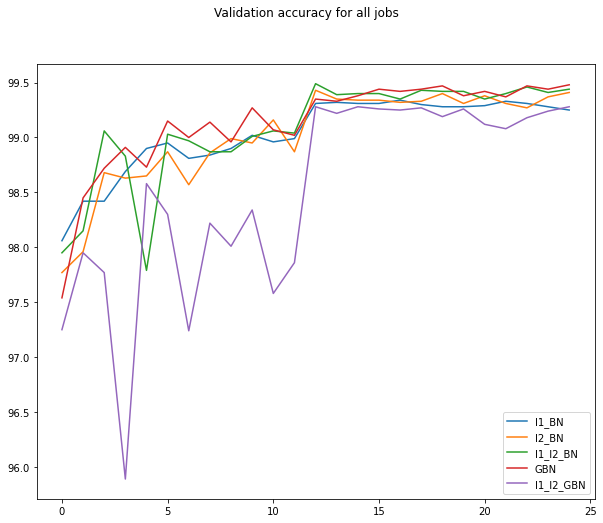

In [ ]:
#results[model_type] = [train_accs, train_losses, test_acc, test_losses, best_model]
lst_plottingJobs = []
lst_plottingLegends = []

for model_type in results:
  lst_plottingJobs.append(results[model_type][2])
  lst_plottingLegends.append(model_type)

plot_multigraph(lst_plottingJobs,lst_plottingLegends,"Validation accuracy for all jobs")

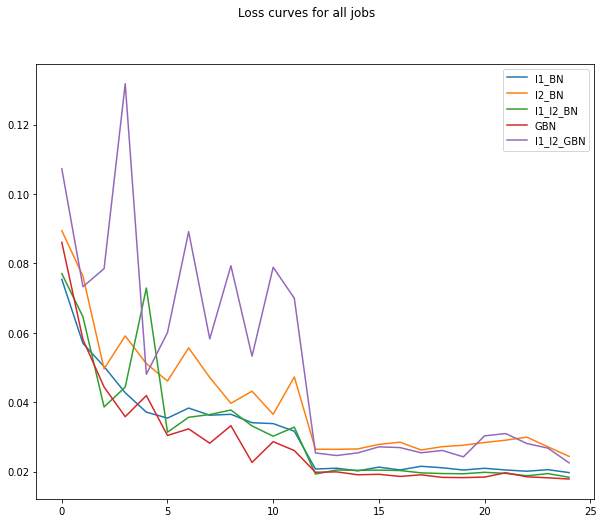

In [ ]:
lst_plottingJobs = []
lst_plottingLegends = []

for model_type in results:
  lst_plottingJobs.append(results[model_type][3])
  lst_plottingLegends.append(model_type)

plot_multigraph(lst_plottingJobs,lst_plottingLegends,"Loss curves for all jobs")


In [ ]:
def plot_misclassified_images(model, device, test_loader, num_of_images = 25):
  plt.figure(figsize=(12,12))
  plt.suptitle('Misclassifications');
  num_images = 0
  #print(len(test_loader))
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      #print(data.shape)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      pred_num = pred.cpu().numpy()
      labels = target.cpu().numpy()
      #print('gues',pred_num[0][0])
      #print('lab',labels[0])
      index = 0
      for label, predict in zip(labels, pred_num):
        if label != predict[0]:
          #print('actual:',label)
          #print('pred',predict[0])
          num_images += 1
          p = plt.subplot((num_of_images/5),5,num_images)
          p.imshow(data[index].cpu().numpy().squeeze(),cmap='gray_r')
          p.set_xticks(()); p.set_yticks(()) # remove ticks
          p.set_title(f'Pred: {predict[0]}, Actual: {label}');
        index +=1
        if num_images == num_of_images:
          break
      if num_images == num_of_images:
          break

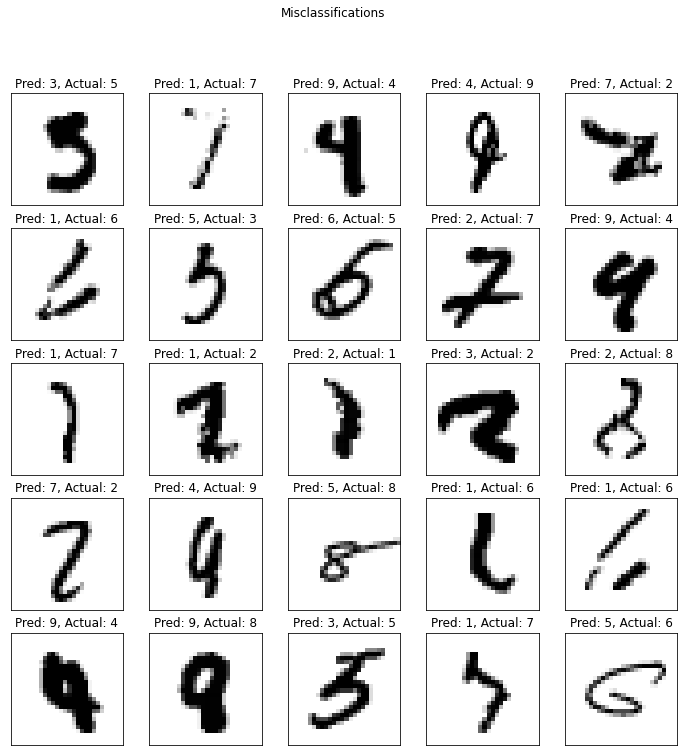

In [ ]:
plot_misclassified_images(results['GBN'][4], device, test_loader, num_of_images = 25)